# Abstract:

Healthcare industry Providers understand that high hospital readmission rates are dangerous and even fatal for at risk patients. But excessive readmission rates can also threaten a hospital's financial health.  Readmissions are already one of the costliest episodes to treat, with hospital costs reaching $41.3 billion for patients readmitted within 30 days of discharge.  The financial burden of hospital readmissions also recently increased when, in 2013 under the Affordable Care Act (ACA), the Centers for Medicare and Medicaid implemented programs designed to penalize hospitals for “excess” readmissions in comparison to “expected” readmissions.  The Readmissions Reduction Program penalizes hospitals up to 3% of their total Medicare payments for high rates of patients readmitted within 30 days of the original discharge.


My focus for this project was to learn, from previous patient hospital encounters, whether readmissions can be avoided by tagging high-risk patients.  By analyzing these past encounters, and associating certain demographics, diagnoses or discharge dispositions, healthcare providers may be able to minimize the readmission rates within their hospital.  Using these patient encounter characteristics that were shown to be related to high readmission rates, I built a machine learning model to assist even further in predicting encounters that are at high risk for readmission.

Since there are many pieces of information belonging to a patient encounter, health care data has many complications and limitations to be aware of when analyzing.  I established the level of the patient data and used aggregations to avoid unnecessary noise in the data as well as to avoid unwanted biases.  The main identifying factors analyzed were patient demographics (age, gender, race), primary diagnosis and patient discharge disposition for the encounter.  Analysis findings show that age, circulatory (or cardiac) and respiratory primary diagnoses and discharges to home (without home health care) and facility transfers are the highest predictors for excess readmission.  Modeling predictions had accuracy of 58%, with 90% recall True Positive predictions of predicting a patient would be readmitted and they were and under 10% predictions of a patient not being readmitted yet they actually were.  With cost-benefit analysis in mind, I believe this is a significant starting point for further evaluation and analysis.

Cost-benefit analysis used: 
Variable costs per day of hospital (hospital incurred): 
- The average cost of a patient's first day is 1246 dollars
- The average cost of a patient's last day 304 dollars 

When a patient is readmitted the hospital, they incur this first day cost twice, whereas an extra day is financially more beneficial. 

https://www.journalacs.org/article/S1072-7515(00)00352-5/fulltext
https://www.beckershospitalreview.com/finance/average-cost-per-inpatient-day-across-50-states.html

I would recommend that hospital healthcare providers engage in more rigorous discharge planning when patients are being discharged to their homes.  It would also be advantageous for inpatient hospital providers of high-risk patients to be provided more in-depth education of their health issues along with resources to assist in further patient education.  Lastly, hospitals, insurance companies and providers would benefit from patient incentives for regular physical exams and preventative care treatment with their outpatient primary care physicians.
This project has a lot of further research planned, including model tuning to lower the False Positive rate of predicting that a patient will be readmitted and they are actually not high risk for readmission and deeper analysis of patient encounter data available.  This project would benefit from collection of more data from a larger range of hospitals or locations and collection of supplementary features of patient medical encounter data.

> **Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence).

> **Objective:**  This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also analyze and interpret a model for biases across key demographic groups. 

### Dataset:

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for this project I am using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008).

### Data Schema:


# Data Evaluation and Preparation:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp

import aequitas as ae
import functools

from importlib import reload
import functions as fun
reload(fun)

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
import pickle

In [2]:
from sklearn import preprocessing, decomposition

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, f1_score, accuracy_score, roc_curve
from sklearn.metrics import precision_score, make_scorer, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBClassifier

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
df = pd.read_csv('diabetes_dataset.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [6]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

In [7]:
df.dtypes

df.shape

(143424, 26)

## Level of EHR Data

It is important to establish whether the dataset is at the line or encounter level. The key fields for this are encounter_id and patient_nbr. Knowing this information will help inform what level of aggregation is necessary for future steps. 

This is commonly overlooked with EHR data.

In [8]:
df.encounter_id.nunique()

101766

In [9]:
df.encounter_id.value_counts()

63415968     6
63184686     6
58316058     6
60016020     6
110310714    6
            ..
59620986     1
11112060     1
94477950     1
103436358    1
396736952    1
Name: encounter_id, Length: 101766, dtype: int64

In [10]:
df.patient_nbr.nunique()

71518

Line level EHR data is the most granular level.  It is a denormalized representation of all things that may happen in a patient encounter.
- For example, could be one row for a new medication, one row for a new diagnosis or a row for a procedure or lab test.

> Understanding levels and aggregating EHR data is so important for analysis and modeling!  There may be multiple rows that can be condensed into one patient or one encounter and without understanding this, the data could have a lot of unnecessary noise and create unwanted errors and biases.

In [11]:
fun.test_level(df)

Dataset is probably at the line level.


The encounter_id count is less than the total rows of the dataset, which means that the data is at line level. 
- This means that there may be a lot of missing/null values because one row is not representative of the entire encounter/visit.
- Aggregation will most definitely be needed!

> I would like to take a quick look at the unique encounter_id values as well as the unique patient_nbr values so I have an idea of what types of aggregation will be needed.

In [12]:
encounters = df['encounter_id']
encounter_dups = df[encounters.isin(encounters[encounters.duplicated()])]
print(encounter_dups.shape)
encounter_dups.head()

(72680, 26)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO
5,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO
7,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,35208-001,None,None,Ch,NO
8,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,16729-001,None,None,Ch,NO
9,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,47918-891,None,None,Ch,NO


In [13]:
patients = df['patient_nbr']
patient_dups = df[patients.isin(patients[patients.duplicated()])]
print(patient_dups.shape)
patient_dups.head()

(105643, 26)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO
5,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO
7,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,35208-001,None,None,Ch,NO
8,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,16729-001,None,None,Ch,NO
9,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,47918-891,None,None,Ch,NO


In [14]:
patient_dups[patient_dups['encounter_id']==76387002]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
29300,76387002,85504905,Caucasian,Female,[40-50),?,1,6,7,9,?,InfectiousDiseases,730,250.81|707,0,0,0,46,9,14,1,47918-902,None,Norm,No,>30


In [15]:
patient_dups[patient_dups['patient_nbr']==80845353]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
49,260166,80845353,Caucasian,Female,[70-80),?,1,1,7,6,?,Family/GeneralPractice,996,999|250.01,0,0,0,27,8,16,0,47918-902,None,None,No,>30
1008,6000072,80845353,Caucasian,Female,[70-80),?,1,1,7,5,?,Family/GeneralPractice,414,250.01|411,0,3,0,54,7,13,0,47918-898,None,None,Ch,>30
27926,73639704,80845353,Caucasian,Female,[80-90),?,1,1,7,4,?,Cardiology,780,E937|E849,0,2,0,45,8,9,0,NaN,None,None,No,NO


> I will go ahead and change the value of 'Ch' to 'Yes'.

In [16]:
df.change.replace({'Ch': 'Yes'}, inplace=True)

df['readmitted_binary'] = df['readmitted']
df.readmitted_binary.replace({'>30': 'Yes', '<30': 'Yes'}, 
                                       inplace=True)
df['readmitted_binary'].value_counts(normalize=True)

NO     0.538599
Yes    0.461401
Name: readmitted_binary, dtype: float64

**The two classes we will be predicting (readmission or not) seem pretty equally balanced, but I still should assess the weights of the two during modeling.**

## NDC Codes: 

**NDC codes are a common format to represent the wide variety of drugs that are prescribed in the United States.** 

The challenge is that there are many codes that map to the same or similar drug. 
> - There are crosswalk connections made to assist with this.  They are mappings to connect different code sets or datasets depending on the data being used.
- The National Drug Codes List site: (https://ndclist.com/)
  - Using the NDC lookup tool I will reduce the dimensionality of the NDC code feature.


In [17]:
ndc_code_df = pd.read_csv('ndc_crosswalk')
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


**To reduce dimensionality:**
> - Join the two datasets on the NDC code columns.  
- Only need the non-proprietary name column from the NDC data.
    - This is the generic name for the drug.
    - This will reduce dimensionality because there are similiar drugs prescribed to the diabetic patients, but many non-generic names for the same drug **AND** different dosage forms for each drug.
        - Each of these different dosages or non-generic name, etc equate to it's own unique NDC code.

> The importance of understanding these differences (or lack there of), is crucial because, like the diagnosis and encounter data, you could end up with a lot of noise or unnecessary data.

In [18]:
df_original = df.copy()
df_original.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Yes,>30,Yes
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Yes,NO,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Yes,NO,NO


In [19]:
df = fun.reduce_ndc(df_original, ndc_code_df)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Yes,>30,Yes,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,NO,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Yes,NO,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Yes,NO,NO,Glipizide


**To check that the reduction worked:**

- The number of unique values for the new columns should be less than the original columns.

In [20]:
orig_codes = df_original['ndc_code'].nunique() 
reduced_codes = df['generic_drug'].nunique()
print(f'Reduced from {orig_codes} to {reduced_codes}')

df_original['ndc_code'].nunique() > df['generic_drug'].nunique()

Reduced from 251 to 22


True

## Grouping Encounters:

> To simplify the aggregation of data further...
- This is to reduce the risk of data leakage of future patient encounters.
    - Data leakage in EHR data is when patient data is shared across the training and test datasets.  It leads to inaccurate labels and demographics that are not reflective of the real world during modeling.
- This will reduce complexity of the data transformation during modeling steps.

In [21]:
non_grouped_field_list = ['generic_drug', 'ndc_code']
grouping_field_list = [c for c in df.columns if c not in non_grouped_field_list]

In [22]:
grouped_test = df.groupby(grouping_field_list)[non_grouped_field_list].agg(lambda x: 
                        list([y for y in x if y is not np.nan])).reset_index()


In [23]:
grouped_test.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,None,None,Yes,NO,NO,"[Glipizide, Insulin Human]","[0049-4110, 47918-902]"
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,None,None,Yes,NO,NO,"[Rosiglitazone Maleate, Human Insulin]","[0173-0863, 68071-1701]"
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,None,None,Yes,NO,NO,"[Glipizide, Human Insulin]","[0049-4110, 68071-1701]"
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,None,None,No,>30,Yes,[Human Insulin],[68071-1701]
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,None,None,No,>30,Yes,[Insulin Human],[47918-902]


In [24]:
grouped_test[grouped_test['patient_nbr']==80845353]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code
30,260166,80845353,Caucasian,Female,[70-80),?,1,1,7,6,?,Family/GeneralPractice,996,999|250.01,0,0,0,27,8,16,0,None,None,No,>30,Yes,[Insulin Human],[47918-902]
773,6000072,80845353,Caucasian,Female,[70-80),?,1,1,7,5,?,Family/GeneralPractice,414,250.01|411,0,3,0,54,7,13,0,None,None,Yes,>30,Yes,[Insulin Human],[47918-898]
21041,73639704,80845353,Caucasian,Female,[80-90),?,1,1,7,4,?,Cardiology,780,E937|E849,0,2,0,45,8,9,0,None,None,No,NO,NO,[],[]


In [25]:
patients = grouped_test['patient_nbr']
patient_test = grouped_test[patients.isin(patients[patients.duplicated()])]
print(patient_test.shape)
# patient_test.head()

(47021, 28)


**Checking that each encounter holds different values for a duplicate patient:**

In [26]:
patient_test[patient_test['patient_nbr']==114715242]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code
31,293058,114715242,Caucasian,Male,[60-70),?,2,6,2,5,?,?,473,996|482,0,0,0,37,8,18,0,None,None,No,>30,Yes,[Insulin Human],[47918-902]
6300,31409370,114715242,Caucasian,Male,[60-70),?,2,6,2,4,?,?,996,486|250,0,2,0,69,5,24,1,None,None,Yes,NO,NO,[Human Insulin],[68071-1701]


> The features that seem to change from encounter to encounter for the same patient are:
- discharge disposition
- time in hospital
- primary diagnosis (and 2nd/3rd)
- number of visits (but still too many zeros)
- number of lab procedures
- number of diagnoses
- number of medications
- number of procedures (but need to check for zeros)
- change in meds
- the ndc_codes - but not necessarily generic medication names (because we grouped/reduced them)

> **- Target feature: readmitted**

**Checking that there are no duplicate encounters:**

In [27]:
encounts = grouped_test['encounter_id']
dup_encounts = grouped_test[encounts.isin(encounts[encounts.duplicated()])]
print(dup_encounts.shape)
dup_encounts.head()


(0, 28)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code


In [28]:
df[df['patient_nbr']==1766367]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug
1335,7753584,1766367,Caucasian,Female,[50-60),?,1,1,7,6,?,InternalMedicine,250.13,599|276,0,0,0,68,9,20,1,68071-1701,None,>8,No,NO,NO,Human Insulin


**Encounter level: Total Number of Rows = Number of Unique Encounters**

In [29]:
print(df.encounter_id.nunique())
df.shape[0]

101766


143482

In [30]:
df['readmitted_binary'].value_counts(normalize=True)
# df['readmitted'].value_counts(normalize=True)

NO     0.538632
Yes    0.461368
Name: readmitted_binary, dtype: float64

## Feature Analysis:

In [31]:
df = pd.read_csv('fully_labeled.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code,second_diagnosis_code,other_diagnosis_code
0,12522,48330783,Caucasian,Female,[80-90),?,Urgent,Home,Transferred,13,?,?,circulatory,0,0,0,68,8,28,2,None,None,Yes,NO,NO,"['Glipizide', 'Insulin Human']","['0049-4110', '47918-902']",circulatory,InfectiousDiseases
1,15738,63555939,Caucasian,Female,[90-100),?,Elective,Transferred,Transferred,12,?,InternalMedicine,circulatory,0,0,0,33,8,18,3,None,None,Yes,NO,NO,"['Rosiglitazone Maleate', 'Human Insulin']","['0173-0863', '68071-1701']",neoplasms,respiratory
2,16680,42519267,Caucasian,Male,[40-50),?,Emergency,Home,EmergencyRoom,1,?,?,neoplasms,0,0,0,51,5,8,0,None,None,Yes,NO,NO,"['Glipizide', 'Human Insulin']","['0049-4110', '68071-1701']",neoplasms,diabetes
3,28236,89869032,AfricanAmerican,Female,[40-50),?,Emergency,Home,EmergencyRoom,9,?,?,diabetes,0,0,0,47,9,17,2,None,None,No,>30,Yes,['Human Insulin'],['68071-1701'],circulatory,injury
4,35754,82637451,Caucasian,Male,[50-60),?,Urgent,Home,Referral,3,?,?,circulatory,0,0,0,31,9,16,6,None,None,No,>30,Yes,['Insulin Human'],['47918-902'],circulatory,diabetes


### Target PCA:

In [32]:
# import patsy
# %pylab inline



# %config InlineBackend.figure_format = 'svg'
# sns.set_style("white")

In [33]:
# collist = list(df.columns)
# collist.remove('readmitted')
# collist.remove('readmitted_binary')
# collist.remove('encounter_id')
# collist.remove('patient_nbr')
# patsy_x_string = (' + ').join(collist)
# patsy_x_string

In [34]:
# y, x = patsy.dmatrices(f'readmitted ~ {patsy_x_string}', 
#                        data=df, return_type="dataframe")

In [35]:
# y = df.readmitted
# numeric_pca_columns = list(df.select_dtypes("int64").columns)
# numeric_pca_columns.remove('encounter_id')
# numeric_pca_columns.remove('patient_nbr')
# numeric_pca_columns

In [36]:
# pca_scaler = preprocessing.StandardScaler()
# x_scaled = x.copy()
# x_scaled = pca_scaler.fit_transform(x_scaled[numeric_pca_columns])
# # scaling because PCA is distance-based
# x = x_scaled

In [37]:
# # Make binary
# y_num = y.copy()
# y_num = y_num.replace('>30', 1)
# y_num = y_num.replace('<30',1)
# y_num = y_num.replace('NO',0)
# y_num.value_counts(normalize=True)

In [38]:
# # label
# y = y.str.replace('NO','Not Readmitted')
# y = y.str.replace('<30','Readmission')
# y = y.str.replace('>30','Readmission')

# y_colors = ['purple', 'yellow']

In [39]:
# fun.plot_PCA_2D(x_scaled, y_num, y.unique(), y_colors)

> Not easily separatable.

To start my analysis into the features of this dataset, I will go ahead and distinguish between the categorical columns and the numerical columns.

In [40]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
time_in_hospital             int64
payer_code                  object
medical_specialty           object
primary_diagnosis_code      object
number_outpatient            int64
number_inpatient             int64
number_emergency             int64
num_lab_procedures           int64
number_diagnoses             int64
num_medications              int64
num_procedures               int64
max_glu_serum               object
A1Cresult                   object
change                      object
readmitted                  object
readmitted_binary           object
generic_drug                object
ndc_code                    object
second_diagnosis_code       object
other_diagnosis_code

In [41]:
cat_cols = df.select_dtypes(include=['O'])
num_cols = df.select_dtypes(exclude=['O'])
print(f'The categorical columns are: \n{list(cat_cols.columns)}\n')
print(f'The numeric columns are: \n{list(num_cols.columns)}')

The categorical columns are: 
['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'primary_diagnosis_code', 'max_glu_serum', 'A1Cresult', 'change', 'readmitted', 'readmitted_binary', 'generic_drug', 'ndc_code', 'second_diagnosis_code', 'other_diagnosis_code']

The numeric columns are: 
['encounter_id', 'patient_nbr', 'time_in_hospital', 'number_outpatient', 'number_inpatient', 'number_emergency', 'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']


### Null and Placeholder Values:

Check for null values.

In [42]:
fun.missing_data(df)

,Total,Percent


No missing values.

In [43]:
df_placeholders, df_cardinality = fun.get_null_get_cardinality(df, cat_cols)

In [44]:
df.shape

(101766, 29)

In [45]:
df_placeholders

,columns,placeholder,total_placeholders
0,race,?,2273
1,gender,Unknown/Invalid,3
2,age,,0
3,weight,?,98569
4,admission_type_id,,0
5,discharge_disposition_id,,0
6,admission_source_id,,0
7,payer_code,?,40256
8,medical_specialty,?,49949
9,primary_diagnosis_code,,0


> Observations:

- Weight = Most of this column is missing!
- A1 test and glucose test have a lot of 'None' values (meaning no test taken)
- payer_code and medical_specialty are high (not planning on using those though)

In [46]:
df.loc[df['gender']=='Unknown/Invalid']

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code,second_diagnosis_code,other_diagnosis_code
30506,98634858,100695042,Other,Unknown/Invalid,[70-80),?,Elective,Home,Referral,1,?,Cardiology,circulatory,0,0,0,5,4,22,5,None,None,Yes,NO,NO,"['Glipizide', 'Pioglitazone']","['0591-0460', '0093-7272']",circulatory,circulatory
75551,226864668,60524946,?,Unknown/Invalid,[60-70),?,Emergency,Home,EmergencyRoom,1,CP,?,injury,0,0,0,38,5,6,1,None,None,No,NO,NO,[],[],injury,Other
82573,257364294,78119847,?,Unknown/Invalid,[70-80),?,Emergency,Transferred,EmergencyRoom,8,CP,?,injury,0,0,0,59,9,21,2,None,None,Yes,NO,NO,"['Metformin Hydrochloride', 'Rosiglitazone Mal...","['0615-7982', '0173-0861']",injury,injury


I am going to drop the three encounters with unknown gender values because they did not result in readmissions so I am not concerned that we are losing pertinent information.

In [47]:
df.drop([30506, 75551, 82573], axis=0, inplace=True)

### Cardinality in Categorical Features:

I can check for high cardinality in the categorical features with the loop above.

In [48]:
df_cardinality

,columns,total_unique,unique_values
0,race,6,"[Caucasian, AfricanAmerican, ?, Other, Asian, ..."
1,gender,3,"[Female, Male, Unknown/Invalid]"
2,age,10,"[[80-90), [90-100), [40-50), [50-60), [60-70),..."
3,weight,10,"[?, [75-100), [50-75), [0-25), [100-125), [25-..."
4,admission_type_id,7,"[Urgent, Elective, Emergency, Unknown, Newborn..."
5,discharge_disposition_id,12,"[Home, Transferred, HomeHealth, Expired_Inpati..."
6,admission_source_id,8,"[Transferred, EmergencyRoom, Referral, Unknown..."
7,payer_code,18,"[?, MC, MD, HM, UN, BC, SP, CP, SI, DM, CM, CH..."
8,medical_specialty,73,"[?, InternalMedicine, Family/GeneralPractice, ..."
9,primary_diagnosis_code,19,"[circulatory, neoplasms, diabetes, respiratory..."


In [49]:
df_cardinality[df_cardinality.total_unique > 20]

,columns,total_unique,unique_values
8,medical_specialty,73,"[?, InternalMedicine, Family/GeneralPractice, ..."
15,generic_drug,493,"[['Glipizide', 'Insulin Human'], ['Rosiglitazo..."
16,ndc_code,10544,"[['0049-4110', '47918-902'], ['0173-0863', '68..."


> **Observations of features with high cardinality (>20 unique values):**

- medical_specialty (73) - various medical providers (specializing in large number of different fields)
    - Many overlap in speciality.

- ndc_code (10544) - There is a **wide** variety of codes for similiar medications. 
    - Each non-generic name gets a unique code as well as the different dosages of each medication.
    - We have already reduced the dimension by mapping the generic medication name to the ndc codes.
    
- generic_drug (493) - This is only because of the variations - I will one hot encode these.


> **These features having high cardinality is not a surprise and just adds more evidence to the importance of understanding the data!**

### Numerical Feature Distributions:

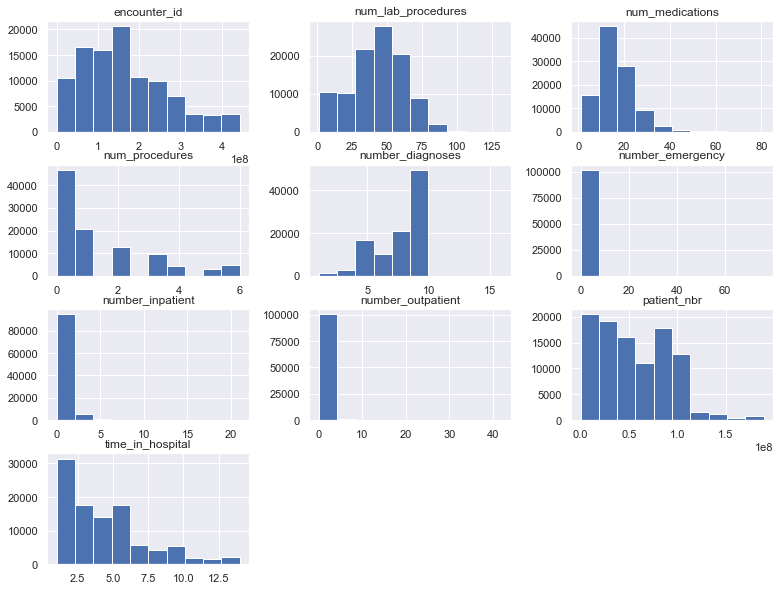

In [50]:
df.hist(figsize=(13,10))
plt.show()

> After evaluating frequency histograms of the numerical columns, it is worth noting that the categories num_lab_procedures and num_medications seem to follow a normal distribution.

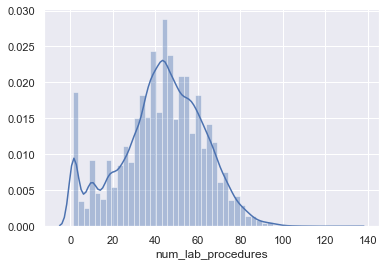

In [51]:
sns.distplot(df.num_lab_procedures)
plt.show()

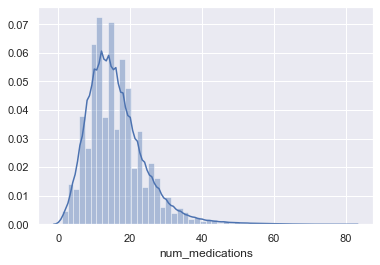

In [52]:
sns.distplot(df.num_medications)
plt.show()

### Patient Demographic Feature Distributions:

> The age feature is bucketed into 10 year groups.

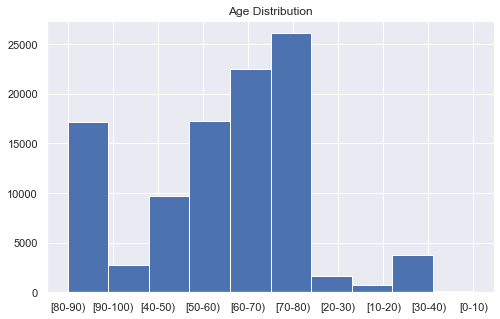

In [53]:
df.age.hist(figsize=(8, 5))
plt.title('Age Distribution')
plt.show()

I am going to switch age to the median age of each bucketed range.

In [54]:
df.age.replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, 
                '[40-50)': 45, '[50-60)': 55,
       '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}, 
               inplace=True)

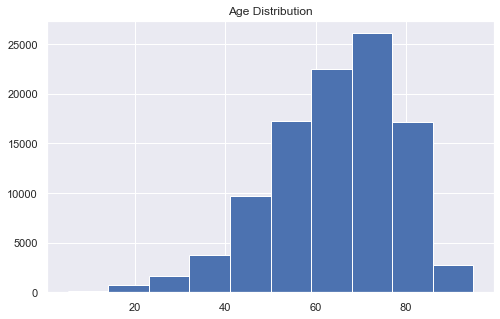

In [55]:
df.age.hist(figsize=(8, 5))
plt.title('Age Distribution')
plt.show()

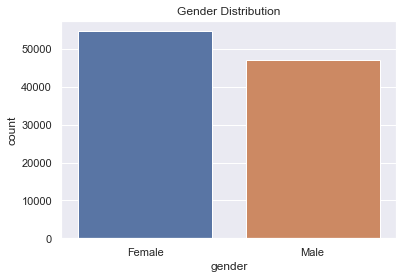

In [56]:
sns.countplot(x="gender", data=df)
plt.title('Gender Distribution')
plt.show()

> **Observations:**

> There are more female patients than male as shown in the gender distribution, but not by much.  I believe this is an insignificant difference.
> - This lines with my assumption that females are generally more likely to seek medical help than males.
    
> The 50-90 age range is highly represented in this dataset.
> - This makes sense with my assumption that younger patients tend to be "more healthy" than older aged patients.

In [57]:
first_list = []

for val in df['generic_drug']:
    first_list.append(val.replace('[', '').replace(']', '').replace("'", '').split(',')[0])
        


df['generic_drug_name'] = first_list


# df.drop(['other_diagnosis_codes'], axis=1, inplace=True)

In [58]:
df.shape

(101763, 30)

## Aggregate for Modeling:

To ensure that the data is on the correct EHR data level, we need to aggregate columns and build the dataset at the appropriate level.

I will transform the dataset using the 'generic_drug' feature.  Then create dummy columns for each unique generic drug name as added engineered features. 

In [59]:
# list columns to use for grouping
groups = [col for col in df.columns if col != 'generic_drug_name']

In [60]:
agg_df, agg_drug_cols = fun.aggregate_dataset(df=df, group_list=groups,
                                         array_field='generic_drug_name')

In [61]:
agg_df.drop([''], axis=1, inplace=True)

In [62]:
agg_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code,second_diagnosis_code,other_diagnosis_code,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,85,?,Urgent,Home,Transferred,13,?,?,circulatory,0,0,0,68,8,28,2,None,None,Yes,NO,NO,"['Glipizide', 'Insulin Human']","['0049-4110', '47918-902']",circulatory,InfectiousDiseases,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,Caucasian,Female,95,?,Elective,Transferred,Transferred,12,?,InternalMedicine,circulatory,0,0,0,33,8,18,3,None,None,Yes,NO,NO,"['Rosiglitazone Maleate', 'Human Insulin']","['0173-0863', '68071-1701']",neoplasms,respiratory,[Rosiglitazone Maleate],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,16680,42519267,Caucasian,Male,45,?,Emergency,Home,EmergencyRoom,1,?,?,neoplasms,0,0,0,51,5,8,0,None,None,Yes,NO,NO,"['Glipizide', 'Human Insulin']","['0049-4110', '68071-1701']",neoplasms,diabetes,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,89869032,AfricanAmerican,Female,45,?,Emergency,Home,EmergencyRoom,9,?,?,diabetes,0,0,0,47,9,17,2,None,None,No,>30,Yes,['Human Insulin'],['68071-1701'],circulatory,injury,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,35754,82637451,Caucasian,Male,55,?,Urgent,Home,Referral,3,?,?,circulatory,0,0,0,31,9,16,6,None,None,No,>30,Yes,['Insulin Human'],['47918-902'],circulatory,diabetes,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [63]:
del agg_drug_cols[0]

In [64]:
agg_drug_cols

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Miglitol',
 'Nateglinide',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Repaglinide',
 'Rosiglitazone_Maleate',
 'Tolazamide',
 'Tolbutamide']

To test the aggregation:

- The row count should be the same as the unique encounter.

In [65]:
len(agg_df) == agg_df['encounter_id'].nunique()

True

## Feature Selection and Preprocessing:

### Feature Selection

For feature selection:

- Look again at numerical column distributions.
- Evaluate percentage of values across columns.

Create seperate lists for chosen categorical and numeric features for subsets.

In [66]:
agg_df.number_diagnoses.value_counts(normalize=True)

9     0.486159
5     0.111946
8     0.104321
7     0.102129
6     0.099850
4     0.054401
3     0.027859
2     0.010053
1     0.002152
16    0.000442
10    0.000167
13    0.000157
11    0.000108
15    0.000098
12    0.000088
14    0.000069
Name: number_diagnoses, dtype: float64

In [67]:
num_cols = agg_df.select_dtypes(exclude='O')
cat_cols = agg_df.select_dtypes(include='O')

In [68]:
agg_df.time_in_hospital.value_counts(normalize=True)

3     0.174484
2     0.169256
1     0.139599
4     0.136828
5     0.097933
6     0.074084
7     0.057575
8     0.043139
9     0.029500
10    0.023014
11    0.018229
12    0.014229
13    0.011890
14    0.010239
Name: time_in_hospital, dtype: float64

In [69]:
agg_df['readmitted_binary'].value_counts(normalize=True)

NO     0.539106
Yes    0.460894
Name: readmitted_binary, dtype: float64

In [70]:
agg_df.change.value_counts(normalize=True)

No     0.538054
Yes    0.461946
Name: change, dtype: float64

In [71]:
agg_df.max_glu_serum.value_counts(normalize=True)

None    0.947466
Norm    0.025520
>200    0.014593
>300    0.012421
Name: max_glu_serum, dtype: float64

In [72]:
agg_df.A1Cresult.value_counts(normalize=True)

None    0.832768
>8      0.080737
Norm    0.049036
>7      0.037460
Name: A1Cresult, dtype: float64

In [73]:
agg_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code,second_diagnosis_code,other_diagnosis_code,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,85,?,Urgent,Home,Transferred,13,?,?,circulatory,0,0,0,68,8,28,2,None,None,Yes,NO,NO,"['Glipizide', 'Insulin Human']","['0049-4110', '47918-902']",circulatory,InfectiousDiseases,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,Caucasian,Female,95,?,Elective,Transferred,Transferred,12,?,InternalMedicine,circulatory,0,0,0,33,8,18,3,None,None,Yes,NO,NO,"['Rosiglitazone Maleate', 'Human Insulin']","['0173-0863', '68071-1701']",neoplasms,respiratory,[Rosiglitazone Maleate],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,16680,42519267,Caucasian,Male,45,?,Emergency,Home,EmergencyRoom,1,?,?,neoplasms,0,0,0,51,5,8,0,None,None,Yes,NO,NO,"['Glipizide', 'Human Insulin']","['0049-4110', '68071-1701']",neoplasms,diabetes,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,89869032,AfricanAmerican,Female,45,?,Emergency,Home,EmergencyRoom,9,?,?,diabetes,0,0,0,47,9,17,2,None,None,No,>30,Yes,['Human Insulin'],['68071-1701'],circulatory,injury,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,35754,82637451,Caucasian,Male,55,?,Urgent,Home,Referral,3,?,?,circulatory,0,0,0,31,9,16,6,None,None,No,>30,Yes,['Insulin Human'],['47918-902'],circulatory,diabetes,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [74]:
agg_df.readmitted_binary.replace({'NO':0, 'Yes':1}, inplace=True)

In [75]:
agg_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'number_outpatient', 'number_inpatient',
       'number_emergency', 'num_lab_procedures', 'number_diagnoses',
       'num_medications', 'num_procedures', 'max_glu_serum', 'A1Cresult',
       'change', 'readmitted', 'readmitted_binary', 'generic_drug', 'ndc_code',
       'second_diagnosis_code', 'other_diagnosis_code',
       'generic_drug_name_array', 'Acarbose', 'Glimepiride', 'Glipizide',
       'Glipizide_And_Metformin_Hcl', 'Glipizide_And_Metformin_Hydrochloride',
       'Glyburide', 'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepir

I have decided on the following features for modeling:

In [76]:
num_feats = ['age', 'num_lab_procedures', 'num_medications', 
             'time_in_hospital',
            'number_diagnoses']  + agg_drug_cols
cat_feats = ['race', 'gender', 'primary_diagnosis_code', 
             'discharge_disposition_id',
                     'second_diagnosis_code', 'other_diagnosis_code',   
             'change']
TARGET = 'readmitted_binary'

In [77]:
feats_df = fun.select_features(agg_df, cat_feats, num_feats, TARGET)
feats_df

,encounter_id,readmitted_binary,race,gender,primary_diagnosis_code,discharge_disposition_id,second_diagnosis_code,other_diagnosis_code,change,age,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,0,Caucasian,Female,circulatory,Home,circulatory,InfectiousDiseases,Yes,85,68,28,13,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,0,Caucasian,Female,circulatory,Transferred,neoplasms,respiratory,Yes,95,33,18,12,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,16680,0,Caucasian,Male,neoplasms,Home,neoplasms,diabetes,Yes,45,51,8,1,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,1,AfricanAmerican,Female,diabetes,Home,circulatory,injury,No,45,47,17,9,9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,35754,1,Caucasian,Male,circulatory,Home,circulatory,diabetes,No,55,31,16,3,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101758,443847548,1,AfricanAmerican,Male,diabetes,Transferred,MentalDisorders,circulatory,Yes,75,51,16,3,9,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
101759,443847782,0,AfricanAmerican,Female,digestive,Transferred,Endocrine,digestive,No,85,33,18,5,9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
101760,443854148,0,Caucasian,Male,InfectiousDiseases,Home,genitourinary,MentalDisorders,Yes,75,53,9,1,13,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
101761,443857166,0,Caucasian,Female,injury,Transferred,BloodDiseases,injury,Yes,85,45,21,10,9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
feats_df.dtypes

encounter_id                                   int64
readmitted_binary                              int64
race                                          object
gender                                        object
primary_diagnosis_code                        object
discharge_disposition_id                      object
second_diagnosis_code                         object
other_diagnosis_code                          object
change                                        object
age                                            int64
num_lab_procedures                             int64
num_medications                                int64
time_in_hospital                               int64
number_diagnoses                               int64
Acarbose                                       uint8
Glimepiride                                    uint8
Glipizide                                      uint8
Glipizide_And_Metformin_Hcl                    uint8
Glipizide_And_Metformin_Hydrochloride         

### Preprocessing - Casting:

In [79]:
def update_dtypes(df, categorical_col_list, predictor):
    df[predictor] = df[predictor].astype(float)
    for col in categorical_col_list:
        df[col] = df[col].astype('str')
    return df

In [80]:
processed_df = update_dtypes(feats_df, cat_feats, TARGET)

In [81]:
processed_df.head()

,encounter_id,readmitted_binary,race,gender,primary_diagnosis_code,discharge_disposition_id,second_diagnosis_code,other_diagnosis_code,change,age,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,0.0,Caucasian,Female,circulatory,Home,circulatory,InfectiousDiseases,Yes,85,68,28,13,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,0.0,Caucasian,Female,circulatory,Transferred,neoplasms,respiratory,Yes,95,33,18,12,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,16680,0.0,Caucasian,Male,neoplasms,Home,neoplasms,diabetes,Yes,45,51,8,1,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,1.0,AfricanAmerican,Female,diabetes,Home,circulatory,injury,No,45,47,17,9,9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,35754,1.0,Caucasian,Male,circulatory,Home,circulatory,diabetes,No,55,31,16,3,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [82]:
processed_df.dtypes

encounter_id                                    int64
readmitted_binary                             float64
race                                           object
gender                                         object
primary_diagnosis_code                         object
discharge_disposition_id                       object
second_diagnosis_code                          object
other_diagnosis_code                           object
change                                         object
age                                             int64
num_lab_procedures                              int64
num_medications                                 int64
time_in_hospital                                int64
number_diagnoses                                int64
Acarbose                                        uint8
Glimepiride                                     uint8
Glipizide                                       uint8
Glipizide_And_Metformin_Hcl                     uint8
Glipizide_And_Metformin_Hydr

In [83]:
# processed_df.to_csv('processed.csv', index=False)

# Train, Validation, and Test Splits:

For a deep learning model, the data needs to be split into three subsets.

- The validation set = used for optimizing the model's hyperparameters during training 
- 60%/20%/20% train/validation/test split
- Randomly sample different patients from each split.

**IMPORTANT** Make sure that a patient's data is not in more than one set!
   - Avoid possible data leakage

In [84]:
train, test = train_test_split(processed_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

65128 train examples
16282 validation examples
20353 test examples


In [85]:
len(train) + len(val) + len(test) == len(processed_df)
# print("Test passed for number of total rows equal!")

True

In [86]:
(train['encounter_id'].nunique() + val['encounter_id'].nunique() + test['encounter_id'].nunique()) == agg_df['encounter_id'].nunique()
# print("Test passed for number of unique patients being equal!")

True

To test against accidental patient data leakage:
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset.
- Total number of rows in original dataset = sum of rows across all three splits.

## Feature Representation Across Splits:

> After splitting EHR data, it's wise to check the distribution of features and demographics to ensure that the groups are represented appropriately across the train, test and validations splits. 

> I created a visualization function that shows how these groups are distributed.

### Target Distribution:

> I will evaluate the distributution of the label across the splits. I am looking for similiar distribution shapes across partitions.

Data before splits: 

readmitted_binary
0.0    54861
1.0    46902
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


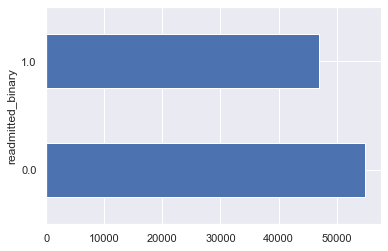

In [87]:
print('Data before splits: \n')
fun.demo_plots(processed_df, TARGET)

Training data: 

readmitted_binary
0.0    35109
1.0    30019
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


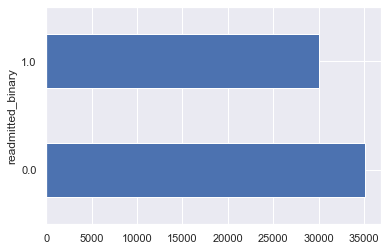

In [88]:
print('Training data: \n')
fun.demo_plots(train, TARGET)

Testing data: 

readmitted_binary
0.0    11022
1.0     9331
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


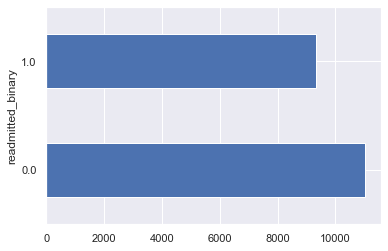

In [89]:
print('Testing data: \n')
fun.demo_plots(test, TARGET)

### Patient Demographic Distributions:

> I will check that my splits are similar in terms of the patient demographic representations. 

> I can use the same function as above to visualize and analyze the full dataset vs. the splits.

Data before splits: 

gender
Female    54708
Male      47055
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


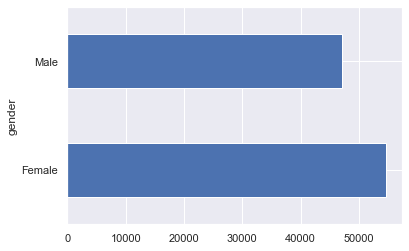

In [90]:
pt_demo_feats = ['race', 'gender', 'age', 'encounter_id']
pt_demo_df = processed_df[pt_demo_feats].groupby('encounter_id').head(1)
pt_demo_df.reset_index(drop=True, inplace=True)

print('Data before splits: \n')
fun.demo_plots(pt_demo_df, 'gender')

Data before splits: 

age
5       161
15      691
25     1657
35     3775
45     9685
55    17256
65    22482
75    26066
85    17197
95     2793
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


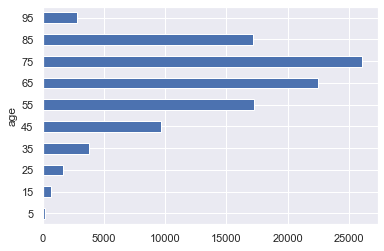

In [91]:
print('Data before splits: \n')
fun.demo_plots(pt_demo_df, 'age')

Training split: 

gender
Female    34975
Male      30153
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


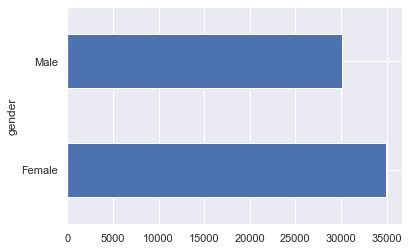

In [92]:
print('Training split: \n')
fun.demo_plots(train, 'gender')

Training split: 

age
5       104
15      434
25     1043
35     2421
45     6185
55    10929
65    14460
75    16688
85    11086
95     1778
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


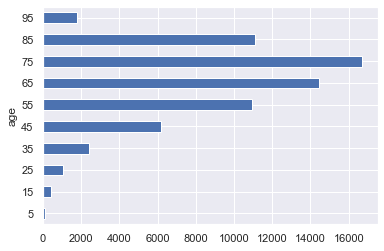

In [93]:
print('Training split: \n')
fun.demo_plots(train, 'age')

Training split: 

gender
Female    10962
Male       9391
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


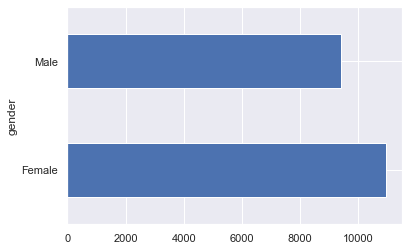

In [94]:
print('Training split: \n')
fun.demo_plots(test, 'gender')

Training split: 

age
5       30
15     150
25     342
35     716
45    1984
55    3535
65    4468
75    5210
85    3365
95     553
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


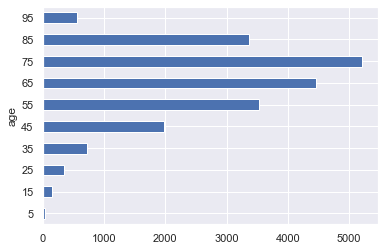

In [95]:
print('Training split: \n')
fun.demo_plots(test, 'age')

Great!  These look pretty similiar and should be representative of all patient groups and data.

# Modeling:

## Scikit Learn Models:

In [96]:
processed_df.drop([ 'Glyburide_And_Metformin_Hydrochloride',
      'Insulin_Human',
       'Metformin_Hcl', 
      'Pioglitazone_Hydrochloride_And_Glimepiride'], axis=1, inplace=True)

In [97]:
processed_df.to_csv('processed.csv', index=False)

In [98]:
X = processed_df.drop(['readmitted_binary', 'encounter_id'], axis=1)
y = processed_df['readmitted_binary']
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.2,
                                                    random_state=42)

X_train.shape[0], X_test.shape[0]

y_train.shape[0], y_test.shape[0]

(81410, 20353)

In [99]:
X_train

,race,gender,primary_diagnosis_code,discharge_disposition_id,second_diagnosis_code,other_diagnosis_code,change,age,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide-metformin_Hydrochloride,Human_Insulin,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
41510,Caucasian,Male,injury,Transferred,Other,circulatory,Yes,75,38,27,2,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
24079,Caucasian,Female,Endocrine,Home,circulatory,circulatory,No,75,48,11,4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91367,AfricanAmerican,Female,diabetes,Home,digestive,NervousSystemDiseases,No,45,28,15,2,9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6237,Caucasian,Male,genitourinary,Home,genitourinary,genitourinary,No,85,44,10,4,7,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
72207,Caucasian,Male,NervousSystemDiseases,Transferred,MentalDisorders,NervousSystemDiseases,Yes,85,54,8,3,8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,Caucasian,Male,respiratory,Home,circulatory,circulatory,No,75,35,12,2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54886,Caucasian,Female,respiratory,Home,respiratory,circulatory,Yes,65,42,18,4,9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
76820,Caucasian,Female,neoplasms,Transferred,circulatory,circulatory,Yes,95,30,16,4,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
860,Caucasian,Female,respiratory,Unknown,respiratory,genitourinary,Yes,65,77,21,12,9,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [101]:
categorical_features = X_train.select_dtypes('O').columns
numerical_features = X_train.select_dtypes(exclude='O').columns

In [102]:
num_pipe = Pipeline([
    ('scaler', 
    StandardScaler())])

cat_pipe = Pipeline([
    ('encoder',
        OneHotEncoder(sparse=False))])

preprocessing = ColumnTransformer(transformers=[
    ('num', num_pipe, numerical_features),
    ('cat', cat_pipe, categorical_features)])
preprocessing

X_train_trans_one = preprocessing.fit_transform(X_train)
X_test_trans_one = preprocessing.transform(X_test)

feature_names = preprocessing.named_transformers_['cat'].\
                named_steps['encoder'].get_feature_names(categorical_features).tolist()

numerical_features = numerical_features.tolist()
X_cols = numerical_features + feature_names
X_train = pd.DataFrame(X_train_trans_one,columns=X_cols)
X_test = pd.DataFrame(X_test_trans_one,columns=X_cols)
X_train.head()

,age,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide-metformin_Hydrochloride,Human_Insulin,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,primary_diagnosis_code_BloodDiseases,primary_diagnosis_code_CongenitalAnomalies,primary_diagnosis_code_DeliveryComplications,primary_diagnosis_code_Endocrine,primary_diagnosis_code_InfectiousDiseases,primary_diagnosis_code_MentalDisorders,primary_diagnosis_code_NervousSystemDiseases,primary_diagnosis_code_Other,primary_diagnosis_code_SenseOrganDiseases,primary_diagnosis_code_SkinDiseases,primary_diagnosis_code_UnknownSymptoms,primary_diagnosis_code_circulatory,primary_diagnosis_code_diabetes,primary_diagnosis_code_digestive,primary_diagnosis_code_genitourinary,primary_diagnosis_code_injury,primary_diagnosis_code_musculoskeletal,primary_diagnosis_code_neoplasms,primary_diagnosis_code_respiratory,discharge_disposition_id_AMA,discharge_disposition_id_Admitted/Outpatient,discharge_disposition_id_Expired_Elsewhere,discharge_disposition_id_Expired_Inpatient,discharge_disposition_id_Home,discharge_disposition_id_HomeHealth,discharge_disposition_id_Hospice,discharge_disposition_id_NeonatalDischarge,discharge_disposition_id_Transferred,discharge_disposition_id_TransferredMedicare,discharge_disposition_id_TransferredToOutpatient,discharge_disposition_id_Unknown,second_diagnosis_code_BloodDiseases,second_diagnosis_code_CongenitalAnomalies,second_diagnosis_code_DeliveryComplications,second_diagnosis_code_Endocrine,second_diagnosis_code_InfectiousDiseases,second_diagnosis_code_MentalDisorders,second_diagnosis_code_NervousSystemDiseases,second_diagnosis_code_Other,second_diagnosis_code_SenseOrganDiseases,second_diagnosis_code_SkinDiseases,second_diagnosis_code_UnknownSymptoms,second_diagnosis_code_circulatory,second_diagnosis_code_diabetes,second_diagnosis_code_digestive,second_diagnosis_code_genitourinary,second_diagnosis_code_injury,second_diagnosis_code_musculoskeletal,second_diagnosis_code_neoplasms,second_diagnosis_code_respiratory,other_diagnosis_code_BloodDiseases,other_diagnosis_code_CongenitalAnomalies,other_diagnosis_code_DeliveryComplications,other_diagnosis_code_Endocrine,other_diagnosis_code_InfectiousDiseases,other_diagnosis_code_MentalDisorders,other_diagnosis_code_NervousSystemDiseases,other_diagnosis_code_Other,other_diagnosis_code_SenseOrganDiseases,other_diagnosis_code_SkinDiseases,other_diagnosis_code_UnknownSymptoms,other_diagnosis_code_circulatory,other_diagnosis_code_diabetes,other_diagnosis_code_digestive,other_diagnosis_code_genitourinary,other_diagnosis_code_injury,other_diagnosis_code_musculoskeletal,other_diagnosis_code_neoplasms,other_diagnosis_code_respiratory,change_No,change_Yes
0,0.566173,-0.258012,1.350644,-0.804627,-0.219706,-0.025524,-0.192981,3.234152,-0.004957,-0.009914,-0.26290,-0.055834,-0.362515,-0.492426,-0.012638,-0.071667,-0.176445,-0.110554,-0.157435,-0.015279,-0.015676,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.566173,0.249861,-0.617850,-0.134886,0.815709,-0.025524,-0.192981,-0.309200,-0.004957,-0.009914,-0.26290,-0.055834,-0.362515,-0.492426,-0.012638,-0.071667,-0.176445,-0.110554,-0.157435,-0.015279,-0.015676,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1

In [103]:
xgb = XGBClassifier()
decision = DecisionTreeClassifier(class_weight= {0: 1, 1: 1.3})
gbc = GradientBoostingClassifier()
knn = KNeighborsClassifier()
forest = RandomForestClassifier(class_weight={0: 1, 1: 1.3})

[12:37:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix: 
 [[0.64209188 0.35790812]
 [0.45122604 0.54877396]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.63      0.64      0.63     11014
    Readmitted       0.57      0.55      0.56      9339

      accuracy                           0.60     20353
     macro avg       0.60      0.60      0.60     20353
  weighted avg       0.60      0.60      0.60     20353
 

True Negative: 0.6420918830579263
False Positive: 0.35790811694207375
False Negative: 0.4512260413320484
True Positive: 0.5487739586679516 

Precision score: 0.5959268099272628
Recall score: 0.595432920862939
F1 score : 0.5955718572955105
Accuracy score: 0.5992728344715766


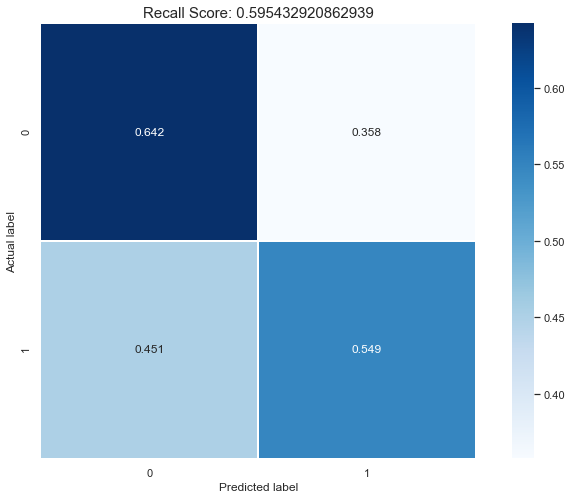

In [104]:
predictions, score = fun.model_test(xgb, X_train, y_train, X_test, y_test)

fun.get_model_performance(predictions, 'Blues', X_test, y_test)

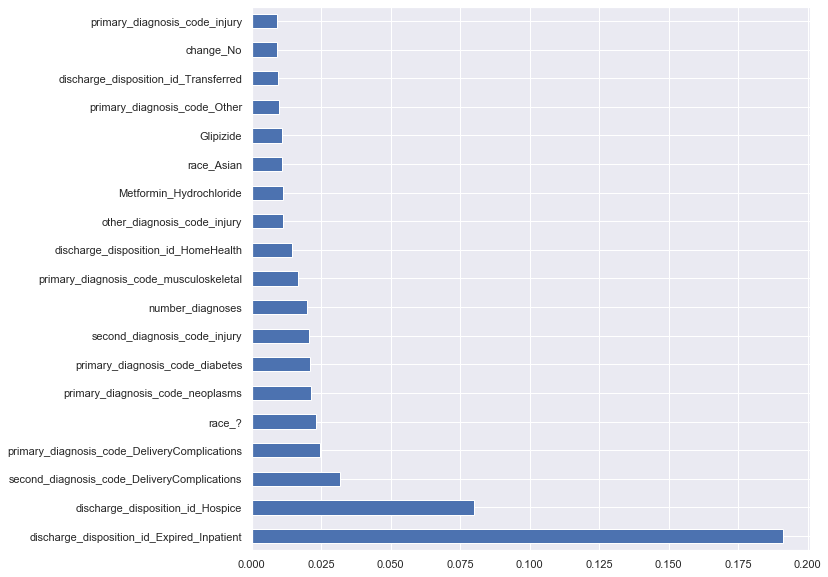

In [105]:
fun.get_important_feats(xgb, X_train)

Confusion Matrix: 
 [[0.57408752 0.42591248]
 [0.49866153 0.50133847]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.58      0.57      0.57     11014
    Readmitted       0.50      0.50      0.50      9339

      accuracy                           0.54     20353
     macro avg       0.54      0.54      0.54     20353
  weighted avg       0.54      0.54      0.54     20353
 

True Negative: 0.5740875249682222
False Positive: 0.42591247503177776
False Negative: 0.49866152693007815
True Positive: 0.5013384730699219 

Precision score: 0.5376925535249585
Recall score: 0.5377129990190721
F1 score : 0.537701263156888
Accuracy score: 0.5407065297499141


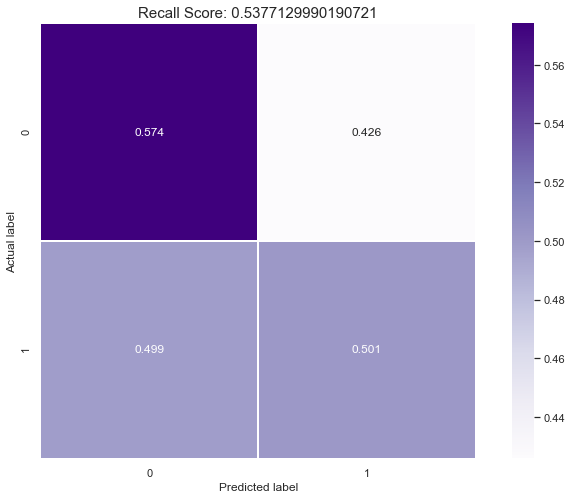

In [106]:
predictions, score = fun.model_test(decision, X_train, y_train, 
                                X_test, y_test)
fun.get_model_performance(predictions, 'Purples', X_test, y_test)

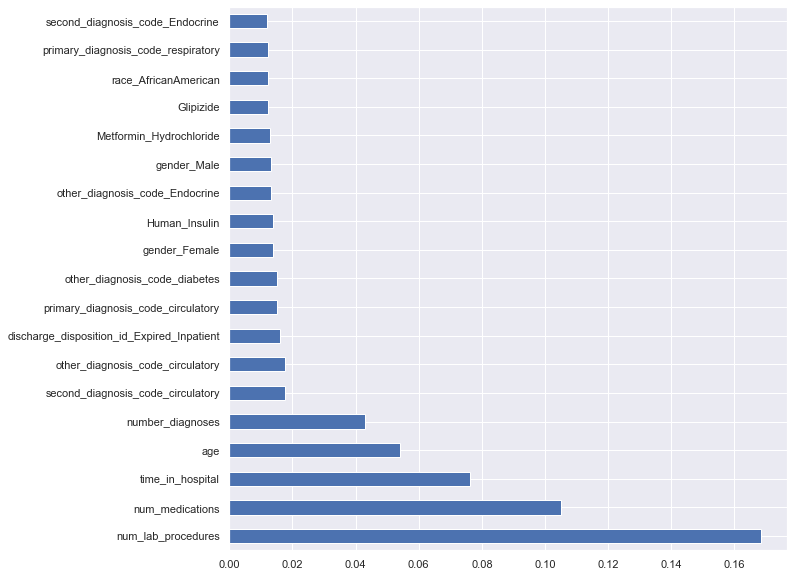

In [107]:
fun.get_important_feats(decision, X_train)

Confusion Matrix: 
 [[0.65952424 0.34047576]
 [0.48442017 0.51557983]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.62      0.66      0.64     11014
    Readmitted       0.56      0.52      0.54      9339

      accuracy                           0.59     20353
     macro avg       0.59      0.59      0.59     20353
  weighted avg       0.59      0.59      0.59     20353
 

True Negative: 0.6595242418739786
False Positive: 0.34047575812602143
False Negative: 0.4844201734661099
True Positive: 0.5155798265338901 

Precision score: 0.5891957566749884
Recall score: 0.5875520342039344
F1 score : 0.5875028629726051
Accuracy score: 0.5934751633665799


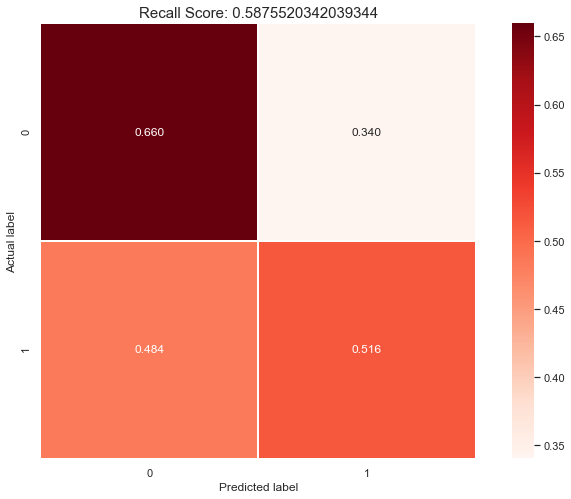

In [108]:
predictions, score = fun.model_test(gbc, X_train, y_train, 
                                X_test, y_test)
fun.get_model_performance(predictions, 'Reds', X_test, y_test)

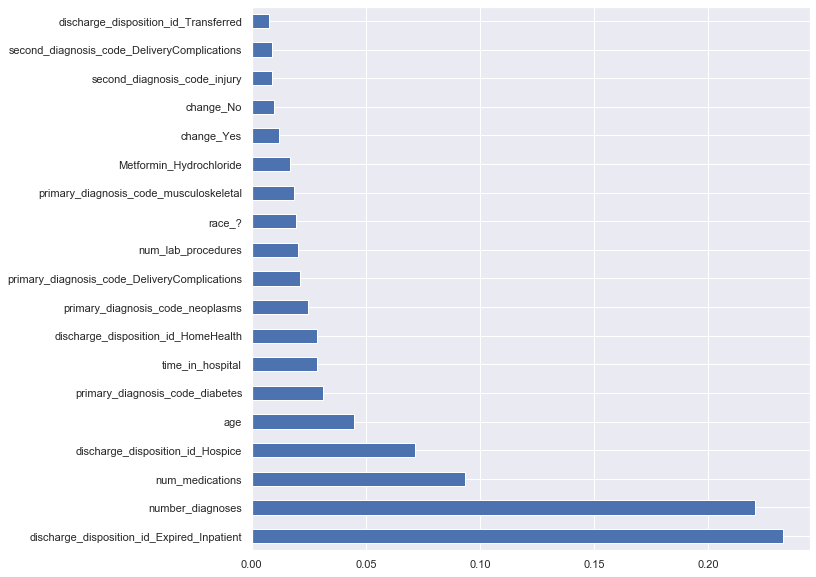

In [109]:
fun.get_important_feats(gbc, X_train)

In [110]:
# predictions, score = fun.model_test(knn, X_train, y_train, 
#                                 X_test, y_test)
# fun.get_model_performance(predictions, 'Pinks', X_test, y_test)

Confusion Matrix: 
 [[0.67314327 0.32685673]
 [0.51997002 0.48002998]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.60      0.67      0.64     11014
    Readmitted       0.55      0.48      0.51      9339

      accuracy                           0.58     20353
     macro avg       0.58      0.58      0.58     20353
  weighted avg       0.58      0.58      0.58     20353
 

True Negative: 0.6731432721990195
False Positive: 0.3268567278009806
False Negative: 0.5199700182032337
True Positive: 0.48002998179676626 

Precision score: 0.5794293939578181
Recall score: 0.5765866269978929
F1 score : 0.5757344128533941
Accuracy score: 0.5845329926792119


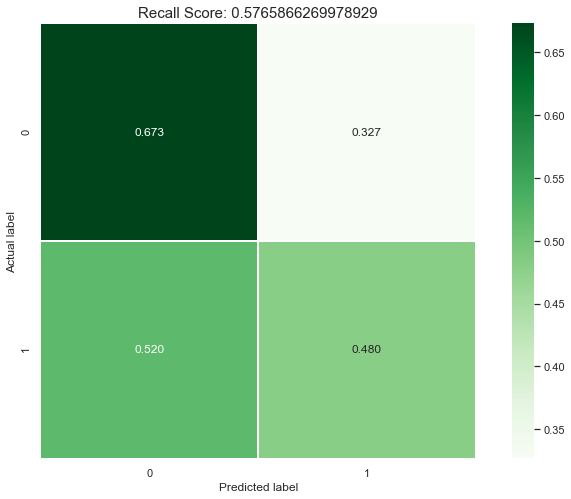

In [111]:
predictions, score = fun.model_test(forest, X_train, y_train, 
                                X_test, y_test)
fun.get_model_performance(predictions, 'Greens', X_test, y_test)

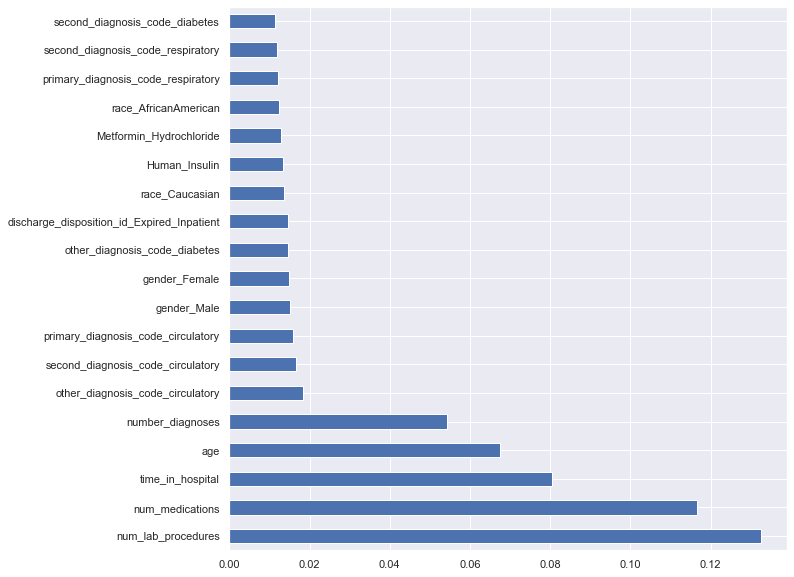

In [112]:
fun.get_important_feats(forest, X_train)

## Deep Learning Model:

### Convert to Tensorflow Dataset:

In [113]:
processed_df = pd.read_csv('processed.csv')
processed_df.head()

,encounter_id,readmitted_binary,race,gender,primary_diagnosis_code,discharge_disposition_id,second_diagnosis_code,other_diagnosis_code,change,age,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide-metformin_Hydrochloride,Human_Insulin,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,0.0,Caucasian,Female,circulatory,Home,circulatory,InfectiousDiseases,Yes,85,68,28,13,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,0.0,Caucasian,Female,circulatory,Transferred,neoplasms,respiratory,Yes,95,33,18,12,8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,16680,0.0,Caucasian,Male,neoplasms,Home,neoplasms,diabetes,Yes,45,51,8,1,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,1.0,AfricanAmerican,Female,diabetes,Home,circulatory,injury,No,45,47,17,9,9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,35754,1.0,Caucasian,Male,circulatory,Home,circulatory,diabetes,No,55,31,16,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [114]:
train, test = train_test_split(processed_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

65128 train examples
16282 validation examples
20353 test examples


> Now it is time to start converting my dataset splits into Tensorflow datasets!

> To execute this conversion, I used boilerplate code that I referenced from Tensorflow's tutorial documentation.

> https://www.tensorflow.org/tutorials/structured_data/feature_columns


In [115]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
X_train, y_train = fun.df_to_dataset(train, TARGET, batch_size=batch_size)
X_val, y_val = fun.df_to_dataset(val, TARGET, batch_size=batch_size)
X_test, y_test = fun.df_to_dataset(test, TARGET, batch_size=batch_size)

In [119]:
categorical_features = ['race', 'gender', 'primary_diagnosis_code', 
                        'discharge_disposition_id',
                       'second_diagnosis_code', 'other_diagnosis_code', 
                        'change']

numerical_features =  ['age', 'num_lab_procedures', 'num_medications',
       'time_in_hospital', 'number_diagnoses', 'Acarbose', 'Glimepiride',
       'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glyburide',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin',
       'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide', 'Pioglitazone',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide']

In [182]:
num_pipe = Pipeline([
    ('scaler', 
    StandardScaler())])

cat_pipe = Pipeline([
    ('encoder',
        OneHotEncoder(sparse=False, handle_unknown='ignore'))])

preprocessing = ColumnTransformer(transformers=[
    ('num', num_pipe, numerical_features),
    ('cat', cat_pipe, categorical_features)])
preprocessing

X_train_trans = preprocessing.fit_transform(X_train)
X_test_trans = preprocessing.transform(X_test)
X_val_trans = preprocessing.transform(X_val)


feature_names = preprocessing.named_transformers_['cat'].\
                named_steps['encoder'].get_feature_names(categorical_features).tolist()


X_cols = numerical_features + feature_names
X_train_trans = pd.DataFrame(X_train_trans,columns=X_cols)
X_test_trans = pd.DataFrame(X_test_trans,columns=X_cols)
X_val_trans = pd.DataFrame(X_val_trans, columns=X_cols)
X_train_trans.head()

,age,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide-metformin_Hydrochloride,Human_Insulin,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,primary_diagnosis_code_BloodDiseases,primary_diagnosis_code_CongenitalAnomalies,primary_diagnosis_code_DeliveryComplications,primary_diagnosis_code_Endocrine,primary_diagnosis_code_InfectiousDiseases,primary_diagnosis_code_MentalDisorders,primary_diagnosis_code_NervousSystemDiseases,primary_diagnosis_code_Other,primary_diagnosis_code_SenseOrganDiseases,primary_diagnosis_code_SkinDiseases,primary_diagnosis_code_UnknownSymptoms,primary_diagnosis_code_circulatory,primary_diagnosis_code_diabetes,primary_diagnosis_code_digestive,primary_diagnosis_code_genitourinary,primary_diagnosis_code_injury,primary_diagnosis_code_musculoskeletal,primary_diagnosis_code_neoplasms,primary_diagnosis_code_respiratory,discharge_disposition_id_AMA,discharge_disposition_id_Admitted/Outpatient,discharge_disposition_id_Expired_Elsewhere,discharge_disposition_id_Expired_Inpatient,discharge_disposition_id_Home,discharge_disposition_id_HomeHealth,discharge_disposition_id_Hospice,discharge_disposition_id_NeonatalDischarge,discharge_disposition_id_Transferred,discharge_disposition_id_TransferredMedicare,discharge_disposition_id_TransferredToOutpatient,discharge_disposition_id_Unknown,second_diagnosis_code_BloodDiseases,second_diagnosis_code_CongenitalAnomalies,second_diagnosis_code_DeliveryComplications,second_diagnosis_code_Endocrine,second_diagnosis_code_InfectiousDiseases,second_diagnosis_code_MentalDisorders,second_diagnosis_code_NervousSystemDiseases,second_diagnosis_code_Other,second_diagnosis_code_SenseOrganDiseases,second_diagnosis_code_SkinDiseases,second_diagnosis_code_UnknownSymptoms,second_diagnosis_code_circulatory,second_diagnosis_code_diabetes,second_diagnosis_code_digestive,second_diagnosis_code_genitourinary,second_diagnosis_code_injury,second_diagnosis_code_musculoskeletal,second_diagnosis_code_neoplasms,second_diagnosis_code_respiratory,other_diagnosis_code_BloodDiseases,other_diagnosis_code_CongenitalAnomalies,other_diagnosis_code_DeliveryComplications,other_diagnosis_code_Endocrine,other_diagnosis_code_InfectiousDiseases,other_diagnosis_code_MentalDisorders,other_diagnosis_code_NervousSystemDiseases,other_diagnosis_code_Other,other_diagnosis_code_SenseOrganDiseases,other_diagnosis_code_SkinDiseases,other_diagnosis_code_UnknownSymptoms,other_diagnosis_code_circulatory,other_diagnosis_code_diabetes,other_diagnosis_code_digestive,other_diagnosis_code_genitourinary,other_diagnosis_code_injury,other_diagnosis_code_musculoskeletal,other_diagnosis_code_neoplasms,other_diagnosis_code_respiratory,change_No,change_Yes
0,-0.062356,-0.460511,1.108070,-0.133848,0.815975,-0.026295,-0.193819,-0.310236,-0.003918,-0.009599,-0.262653,-0.056192,2.740461,-0.491887,-0.012392,-0.070599,-0.178498,-0.109669,-0.156655,-0.015676,-0.015178,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.190119,-1.629922,-0.493711,1.877363,0.815975,-0.026295,-0.193819,-0.310236,-0.003918,-0.009599,3.807309,-0.056192,-0.364902,-0.491887,-0.012392,-0.070599,-0.178498,-0.109669,-0.156655,-0.015676,-0.015178,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [121]:
X_train_trans.shape

(65128, 100)

# Deep Learning Model:

In [122]:
X_train_trans.shape[-1]

100

> Like I mentioned earlier in the analysis, I will assess the weights of the target variables to give more weight to readmissions (1).

In [123]:
from sklearn.utils import class_weight

In [124]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [125]:
class_weights = dict(enumerate(class_weights))

In [126]:
class_weights

{0: 0.9270625747309685, 1: 1.0853943070461969}

In [183]:
counts = np.bincount(y_train)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.5 / counts[1]



Number of positive samples in training data: 30002 (46.07% of total)


> Building out the model:

In [184]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),]


def build_sequential_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(256, activation="relu"),
#         tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    return model

def build_model(X_train, y_train, X_val, y_val, 
                optimizer=tf.keras.optimizers.Adam(1e-2), 
                epochs=5, build_fn=build_sequential_model):
    model = build_fn()
    model.compile(
        optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                verbose=1,
                                patience=5,
                                mode='max',
                                restore_best_weights=False) 

    class_weight = {0: weight_for_0, 1: weight_for_1}
#     class_weight = class_weights
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        callbacks=early_stop,
                        epochs=epochs, class_weight=class_weight, 
                        batch_size=248)
    return model, history 

In [185]:
diabetes_model, history = build_model(X_train_trans, y_train, 
                                      X_val_trans, y_val,  
                                                    epochs=30)

Epoch 1/30
263/263 [==============================] - 2s 4ms/step - loss: 2.5691e-05 - accuracy: 0.5016 - precision: 0.4789 - recall: 0.9056 - auc: 0.5681 - val_loss: 0.6877 - val_accuracy: 0.5526 - val_precision: 0.5049 - val_recall: 0.8226 - val_auc: 0.6201
Epoch 2/30
263/263 [==============================] - 1s 3ms/step - loss: 2.4854e-05 - accuracy: 0.5463 - precision: 0.5045 - recall: 0.8931 - auc: 0.6214 - val_loss: 0.6950 - val_accuracy: 0.5383 - val_precision: 0.4957 - val_recall: 0.8971 - val_auc: 0.6309
Epoch 3/30
263/263 [==============================] - 1s 3ms/step - loss: 2.4580e-05 - accuracy: 0.5458 - precision: 0.5038 - recall: 0.8984 - auc: 0.6292 - val_loss: 0.7035 - val_accuracy: 0.5339 - val_precision: 0.4932 - val_recall: 0.9096 - val_auc: 0.6322
Epoch 4/30
263/263 [==============================] - 1s 3ms/step - loss: 2.4420e-05 - accuracy: 0.5505 - precision: 0.5060 - recall: 0.8986 - auc: 0.6393 - val_loss: 0.6993 - val_accuracy: 0.5324 - val_precision: 0.4923

## Model Performance:

In [186]:
metrics_diab = diabetes_model.evaluate(X_test_trans, y_test)
print("Metrics", metrics_diab)

637/637 [==============================] - 1s 897us/step - loss: 0.6861 - accuracy: 0.5568 - precision: 0.5148 - recall: 0.8771 - auc: 0.6334
Metrics [0.6861266493797302, 0.5568220615386963, 0.5147676467895508, 0.877131998538971, 0.6333827972412109]


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


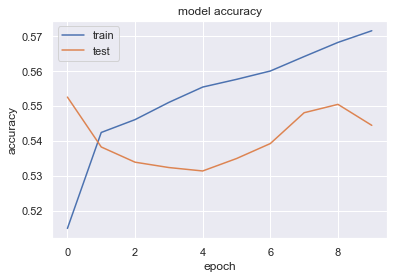

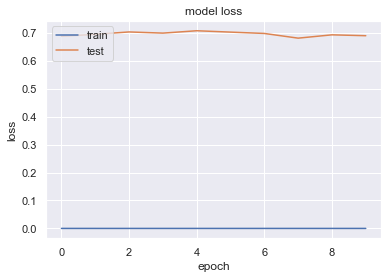

In [187]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [188]:
preds = diabetes_model.predict(X_test_trans).round()

In [189]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

array([[3002, 7853],
       [1167, 8331]])

In [190]:
cnf_matrix = metrics.confusion_matrix(y_test, preds, normalize='true')
cnf_matrix

array([[0.27655458, 0.72344542],
       [0.12286797, 0.87713203]])

In [191]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.72      0.28      0.40     10855
         1.0       0.51      0.88      0.65      9498

    accuracy                           0.56     20353
   macro avg       0.62      0.58      0.52     20353
weighted avg       0.62      0.56      0.52     20353



In [194]:
# X_train_trans.head()

In [195]:
# X_train_trans.columns

## Feature Selection:

> Here I will drop all features except time spent in hospital, gender, age, primary diagnoses and discharge disposition.

In [199]:
# X_train_trans  X_test_trans
X_val_trans.drop(['num_lab_procedures', 'num_medications', 
       'number_diagnoses', 'Acarbose', 'Glimepiride', 'Glipizide',
       'Glipizide_And_Metformin_Hcl', 'Glipizide_And_Metformin_Hydrochloride',
       'Glyburide', 'Glyburide-metformin_Hydrochloride', 'Human_Insulin',
       'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide', 'Pioglitazone',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide',
       'primary_diagnosis_code_BloodDiseases',
       'primary_diagnosis_code_CongenitalAnomalies',
       'primary_diagnosis_code_DeliveryComplications',
       'primary_diagnosis_code_Endocrine',
       'primary_diagnosis_code_InfectiousDiseases',
       'primary_diagnosis_code_MentalDisorders',
       'primary_diagnosis_code_NervousSystemDiseases',
       'primary_diagnosis_code_Other',
       'primary_diagnosis_code_SenseOrganDiseases',
       'primary_diagnosis_code_SkinDiseases',
       'primary_diagnosis_code_UnknownSymptoms',
       'primary_diagnosis_code_neoplasms',
      'discharge_disposition_id_AMA',
       'discharge_disposition_id_Admitted/Outpatient',
       'discharge_disposition_id_Expired_Elsewhere',
       'discharge_disposition_id_Expired_Inpatient',
      'discharge_disposition_id_HomeHealth',
       'discharge_disposition_id_Hospice',
       'discharge_disposition_id_NeonatalDischarge',
       'discharge_disposition_id_Unknown',
       'second_diagnosis_code_BloodDiseases',
       'second_diagnosis_code_CongenitalAnomalies',
       'second_diagnosis_code_DeliveryComplications',
       'second_diagnosis_code_Endocrine',
       'second_diagnosis_code_InfectiousDiseases',
       'second_diagnosis_code_MentalDisorders',
       'second_diagnosis_code_NervousSystemDiseases',
       'second_diagnosis_code_Other',
       'second_diagnosis_code_SenseOrganDiseases',
       'second_diagnosis_code_SkinDiseases',
       'second_diagnosis_code_UnknownSymptoms',
       'second_diagnosis_code_circulatory', 'second_diagnosis_code_diabetes',
       'second_diagnosis_code_digestive',
       'second_diagnosis_code_genitourinary', 'second_diagnosis_code_injury',
       'second_diagnosis_code_musculoskeletal',
       'second_diagnosis_code_neoplasms', 'second_diagnosis_code_respiratory',
       'other_diagnosis_code_BloodDiseases',
       'other_diagnosis_code_CongenitalAnomalies',
       'other_diagnosis_code_DeliveryComplications',
       'other_diagnosis_code_Endocrine',
       'other_diagnosis_code_InfectiousDiseases',
       'other_diagnosis_code_MentalDisorders',
       'other_diagnosis_code_NervousSystemDiseases',
       'other_diagnosis_code_Other', 'other_diagnosis_code_SenseOrganDiseases',
       'other_diagnosis_code_SkinDiseases',
       'other_diagnosis_code_UnknownSymptoms',
       'other_diagnosis_code_circulatory', 'other_diagnosis_code_diabetes',
       'other_diagnosis_code_digestive', 'other_diagnosis_code_genitourinary',
       'other_diagnosis_code_injury', 'other_diagnosis_code_musculoskeletal',
       'other_diagnosis_code_neoplasms', 'other_diagnosis_code_respiratory',
       'change_No', 'change_Yes'], axis=1, inplace=True)

In [200]:
diabetes_model, history = build_model(X_train_trans, y_train, 
                                      X_val_trans, y_val,  
                                                    epochs=30)

Epoch 1/30
263/263 [==============================] - 2s 4ms/step - loss: 2.5793e-05 - accuracy: 0.4784 - precision: 0.4684 - recall: 0.9478 - auc: 0.5400 - val_loss: 0.7253 - val_accuracy: 0.4712 - val_precision: 0.4612 - val_recall: 0.9708 - val_auc: 0.5649
Epoch 2/30
263/263 [==============================] - 1s 3ms/step - loss: 2.5550e-05 - accuracy: 0.4868 - precision: 0.4726 - recall: 0.9506 - auc: 0.5677 - val_loss: 0.7293 - val_accuracy: 0.4784 - val_precision: 0.4642 - val_recall: 0.9566 - val_auc: 0.5651
Epoch 3/30
263/263 [==============================] - 1s 3ms/step - loss: 2.5538e-05 - accuracy: 0.4853 - precision: 0.4711 - recall: 0.9527 - auc: 0.5687 - val_loss: 0.7240 - val_accuracy: 0.4679 - val_precision: 0.4595 - val_recall: 0.9684 - val_auc: 0.5620
Epoch 4/30
263/263 [==============================] - 1s 3ms/step - loss: 2.5499e-05 - accuracy: 0.4884 - precision: 0.4714 - recall: 0.9439 - auc: 0.5744 - val_loss: 0.7267 - val_accuracy: 0.4718 - val_precision: 0.4615

637/637 [==============================] - 1s 886us/step - loss: 0.7147 - accuracy: 0.5107 - precision: 0.4869 - recall: 0.9029 - auc: 0.5768
Metrics [0.7147412300109863, 0.5106863975524902, 0.4869130849838257, 0.9029269218444824, 0.5768078565597534]
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


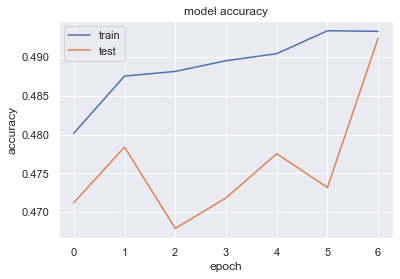

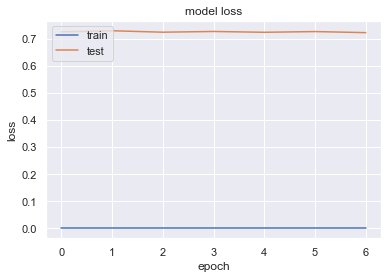

In [201]:
metrics_diab = diabetes_model.evaluate(X_test_trans, y_test)
print("Metrics", metrics_diab)

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## Model Evaluation Metrics:

In [202]:
preds = diabetes_model.predict(X_test_trans).round()

In [203]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

array([[1818, 9037],
       [ 922, 8576]])

In [204]:
cnf_matrix = metrics.confusion_matrix(y_test, preds, normalize='true')
cnf_matrix

array([[0.16748042, 0.83251958],
       [0.09707307, 0.90292693]])

In [205]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.66      0.17      0.27     10855
         1.0       0.49      0.90      0.63      9498

    accuracy                           0.51     20353
   macro avg       0.58      0.54      0.45     20353
weighted avg       0.58      0.51      0.44     20353



In [206]:
recall = recall_score(y_test, preds, average='binary')

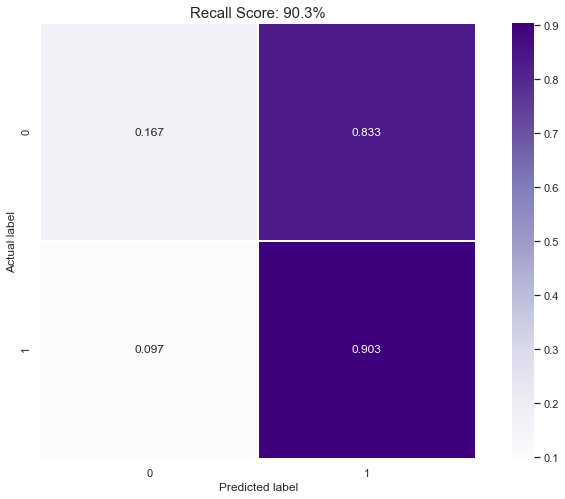

In [207]:
plt.figure(figsize=(13,8))
sns.heatmap(cnf_matrix, 
        annot=True, fmt=".3f", linewidths=.5, square = True, 
                cmap = 'Purples');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = (f'Recall Score: {recall.round(3)*100}%')
plt.title(all_sample_title, size = 15);

> Precision-recall trade-off:

> The more the model tries to eliminate false negatives (increase precision):
    the more the model will error on the side of false positives.

> Forced to classify as True at the possibility that it might be False.

> This means that sometimes actual negatives will be classified as "True" = True Positives

Minimizing FNs = higher FPs.

Increasing TPs = TNs decrease

>  Precision and recall are both right over 50%
> This shows decent trade-off.

**Definitely has room for improvement!**

## Future Model Work:

We need to identify patients who are high risk for readmission as well as not overly label all patients as high risk.
So, both precison and recall are important measure.

For future work on model performance:
- can add more complex layers to model build


# Model Predictions:

> Make dataframe from model results to better visualize. 
- The Aequitas toolkit requires a dataframe.
- predictions = score
- actual = label_value

In [149]:
# prob_outputs = {
#     "pred": preds.flatten(),
#     "actual_value": y_test}
# prob_df = pd.DataFrame(prob_outputs)

In [150]:
# prob_df

In [151]:
def add_predictions(df_test, pred_np,  y_test):
    df_test['score'] = pred_np
    df_test['label_value'] = y_test
    return df_test

In [210]:
predictions_test_df = add_predictions(X_test, preds, 
                                           y_test)                                

In [154]:
# predictions_test_df

In [155]:
# predictions_test_df[['time_in_hospital', 
#                                                'score', 'label_value']].head()

# Conclusion and Recommendations:

# Conclusions and Recommendations:¶


-  Patient home discharge (without home healthcare) is the leading disposition related to readmissions usually due to underestimations made about the extent of a patient’s or family member’s ability to correctly follow discharge instructions or follow-up care as well as the push of administration to quickly discharge patients.
I would recommend that hospital healthcare providers engage in more rigorous discharge planning when patients are being discharged to their homes.  The discharge planning should start earlier (beginning of encounter) and include family members so that no information is lost and no assumptions are made.  A more in-depth protocol for follow-up care with actual patient check-ins made, or trigger patient for non-compliance and attempt deeper check-in methods.  


- It would be advantageous for inpatient hospital providers of high-risk patients to be provided with more in-depth education of their health issues along with resources to assist in further patient education.  We are aware from analysis that patients in the age range of 50-90, have a diagnosis of circulatory (cardiac) disease, respiratory disease or one related to digestive issues, trauma, genitourinary or musculoskeletal diseases and are discharged to home or another facility are at the highest risk of readmission, so these are the patients we would want to spend more time with to assess their understanding of their current health situation.  We would want to provide as much assistance in guiding these patients to being including in their wellness and health.

- Hospitals, insurance companies and providers would benefit from patient incentives for regular physical exams and preventative care treatment with their outpatient primary care physicians.  Insurance companies already give incentives in the form of gift cards or waiving copay fees for physicals, but these can be pushed further for high-risk patients.  These providers can make it more enticing for patients to be involved in and actively participate in their health and well-being.

# Appendix:

## Limitations:

- Not all patient demographics were included in this dataset.  
- All geographic hospitals were represented which can lead to race and gender biases.
- There were missing features that would greatly assist with predictions.

### Future Work for Limitations:

**Features to collect for future work:**
- time between admissions
- patient weight
- patient temperature
- specificity on types of radiology and lab testing
- broader past patient records 

**Push the biases with collecting better representated patient data across more regions.**

**Collect cardiac / circulatory subset diagnoses for high risk patients.**

## Evaluating Potential Model Biases with Aequitas Toolkit

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [211]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = predictions_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


## Group Selection:

Here I can chose the reference group for analysis.

In [212]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


## Race and Gender Bias Analysis for Patient Selection

To check for significant bias in the model cross race and gender:
- Plot metrics that are important for patient selection (with race and gender).
- Check for significant bias in the model across any of the groups.

In [213]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,17613,race,?,118,357,67,109,248,51,160,315,475,20353
1,0,binary 0/1,17613,race,AfricanAmerican,3330,473,1725,170,303,1605,1775,2028,3803,20353
2,0,binary 0/1,17613,race,Asian,57,70,36,18,52,21,39,88,127,20353
3,0,binary 0/1,17613,race,Caucasian,13699,1518,7012,529,989,6687,7216,8001,15217,20353
4,0,binary 0/1,17613,race,Hispanic,256,156,124,45,111,132,177,235,412,20353
5,0,binary 0/1,17613,race,Other,153,166,73,51,115,80,131,188,319,20353
6,0,binary 0/1,17613,gender,Female,9638,1369,4920,434,935,4718,5152,5855,11007,20353
7,0,binary 0/1,17613,gender,Male,7975,1371,4117,488,883,3858,4346,5000,9346,20353


In [214]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,?,0.32,0.79,0.31,0.57,0.21,0.68,0.69,0.43,0.01,0.25,0.34
1,race,AfricanAmerican,0.90,0.15,0.36,0.52,0.85,0.10,0.64,0.48,0.19,0.88,0.47
2,race,Asian,0.54,0.59,0.26,0.63,0.41,0.46,0.74,0.37,0.00,0.45,0.31
3,race,Caucasian,0.93,0.12,0.35,0.51,0.88,0.07,0.65,0.49,0.78,0.90,0.47
4,race,Hispanic,0.75,0.47,0.29,0.48,0.53,0.25,0.71,0.52,0.01,0.62,0.43
5,race,Other,0.61,0.61,0.31,0.48,0.39,0.39,0.69,0.52,0.01,0.48,0.41
6,gender,Female,0.92,0.16,0.32,0.51,0.84,0.08,0.68,0.49,0.55,0.88,0.47
7,gender,Male,0.89,0.18,0.36,0.52,0.82,0.11,0.64,0.48,0.45,0.85,0.47


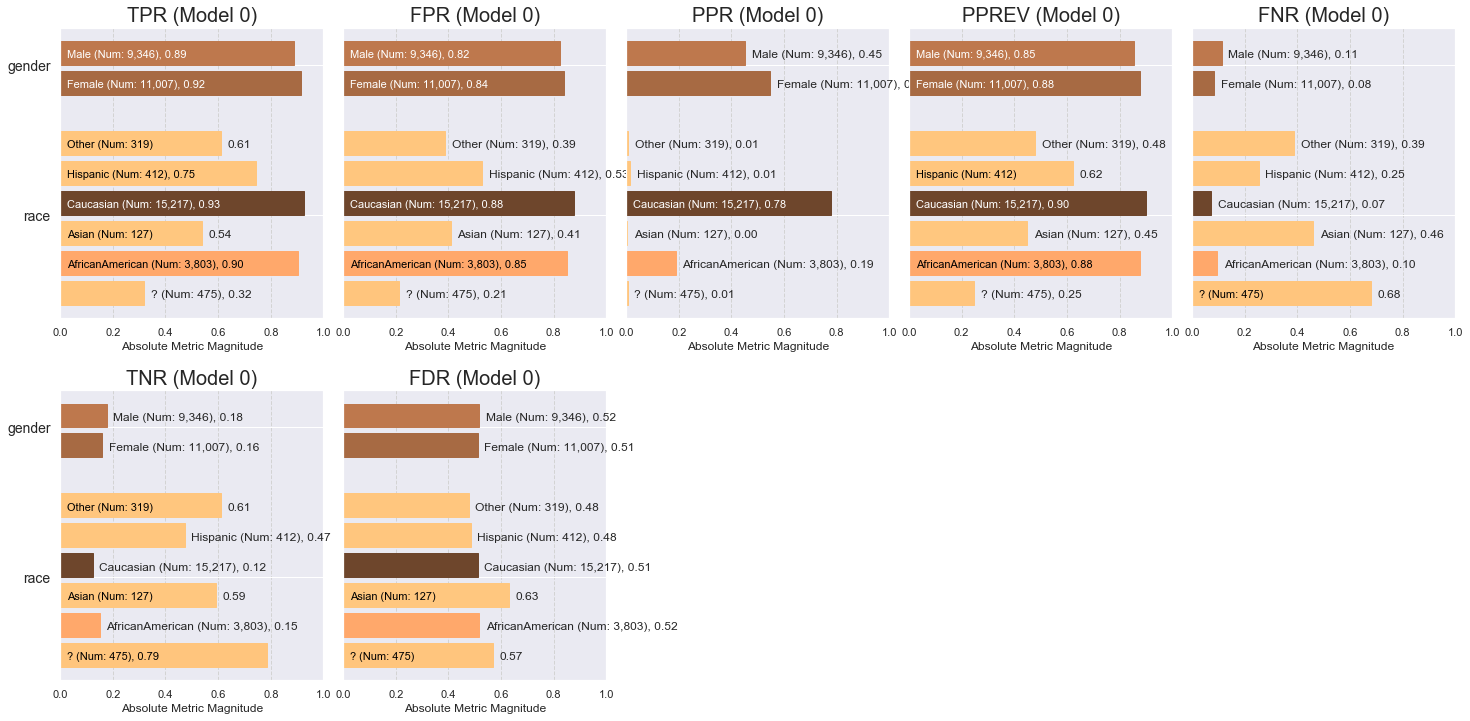

<Figure size 432x288 with 0 Axes>

In [215]:
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 
                                             'pprev', 'fnr', 'tnr', 'fdr'], ncols=5)

From the visualizations above, we can see, the model shows no noticeable bias in gender (between male and female groups), and almost no bias in race, EXCEPT for PPR (Positive Predictive Rate, or precision).

PPR looks very much higher for Caucasian group (much higher precision), which also means much lower portion of False Positives among positive predictions. 

This means that among the patients selected by our model for this drug program, the selected Caucasian people have a much higher chance of being actually fit (the right choice) for the program as compared to other groups, especially Hispanics or Asians, which will have a higher probability of NOT being a good fit for the program. 

This can be a useful piece of info to know in advance when working with this model.

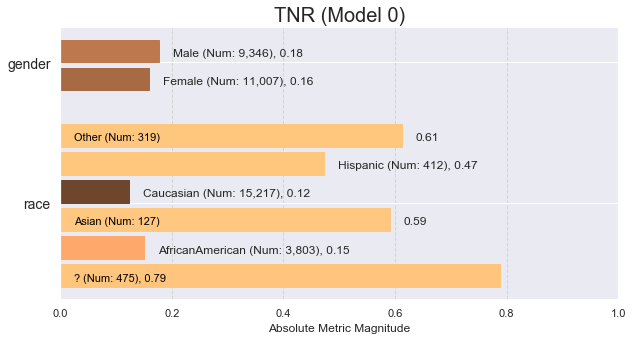

In [216]:
tnr = aqp.plot_group_metric(clean_xtab, 'tnr')

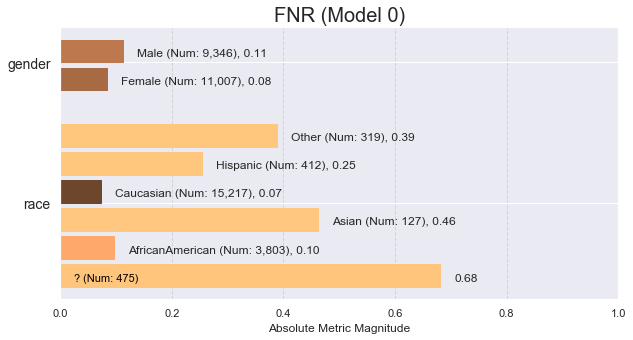

In [217]:
fnr = aqp.plot_group_metric(clean_xtab, 'fnr')

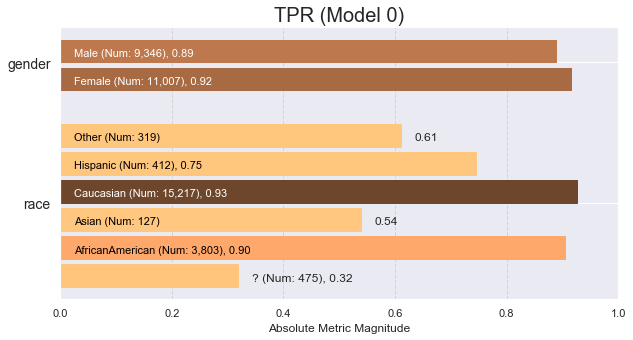

In [218]:
tpr = aqp.plot_group_metric(clean_xtab, 'tpr')

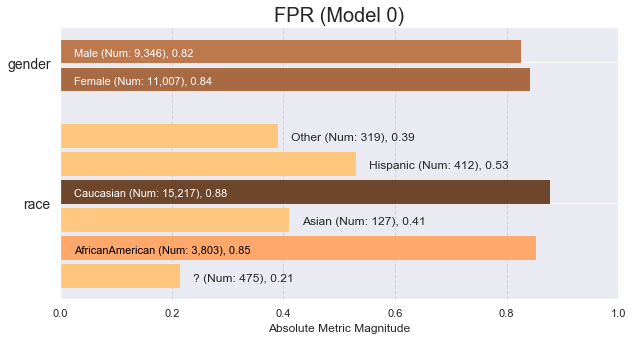

In [219]:
fpr = aqp.plot_group_metric(clean_xtab, 'fpr')

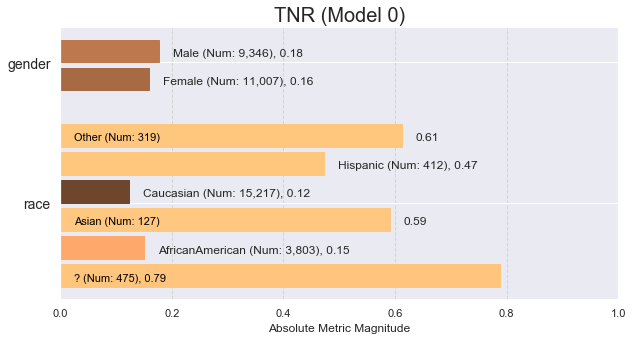

In [220]:
tnr = aqp.plot_group_metric(clean_xtab, 'tnr')

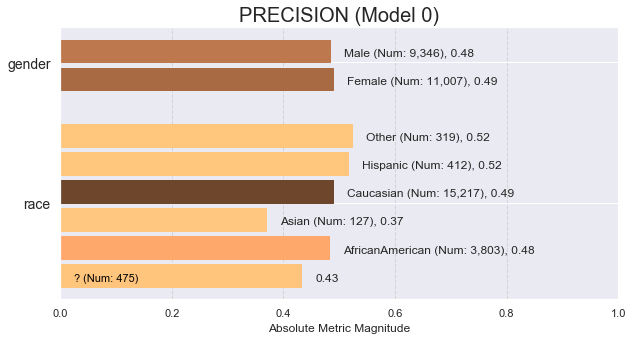

In [221]:
precision = aqp.plot_group_metric(clean_xtab, 'precision')

There isn't any significant bias in the model for either race or gender.

## Fairness Analysis: 

Let's look at the visualization of the fairness evaluation for gender and race to analyze whether there is disparity.

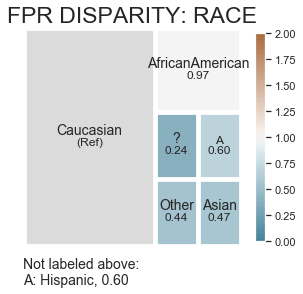

In [222]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                   attribute_name='race')


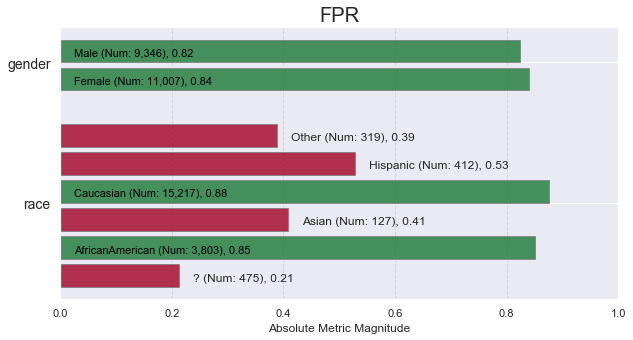

In [223]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title='race')

Caucasion is the reference (1) for the probability of being indentified falsely. 
- The other races are ...

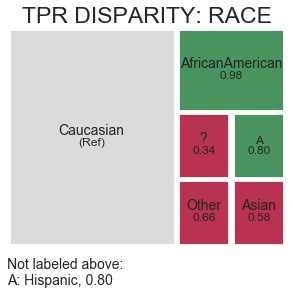

In [224]:
tpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='tpr',
                                                     attribute_name='race')

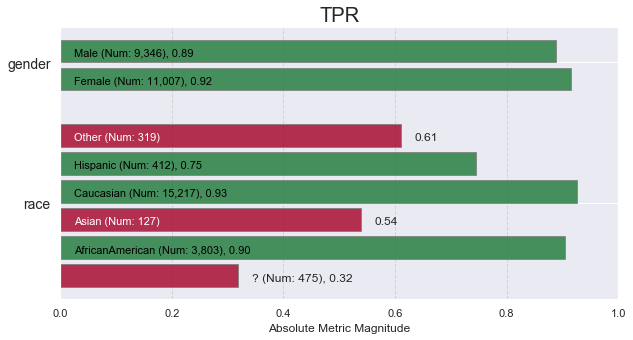

In [225]:
tpr_fairness = aqp.plot_fairness_group(fdf, group_metric='tpr', title='race')

In [226]:
# Reference group fairness plot

## Model Interpretability with Shapley Values

- Using Open Source Library Shap - https://github.com/slundberg/shap
- Developed by Su-In Lee's lab at the University of Washington, and Microsoft Research

In [173]:
# adapted from https://github.com/kweinmeister/notebooks/blob/master/tensorflow-shap-college-debt.ipynb
# https://towardsdatascience.com/understand-how-your-tensorflow-model-is-making-predictions-d0b3c7e88500

In [227]:
import shap
shap.initjs()

### Train Model without Dense Features

Steps:

- Use Kmeans clustering to summarize data
- Shapley can be the computation time so cluster the features with Kmeans


### Use KMeans to Summarize Dataset

In [233]:
# select a set of background examples to take an expectation over
# background = X_train_trans[(X_train_trans.shape, 100, 
#                                             replace=False)]

background = X_train_trans.sample(n=100, random_state=42)

# explain predictions of the model on four images
# e = shap.DeepExplainer(diabetes_model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
# shap_values = e.shap_values(X_test_trans)

# plot the feature attributions
# shap.image_plot(shap_values, -x_test[1:5])

In [234]:
# df_test_summary = shap.kmeans(X_test_trans.values, 25)

In [240]:
df_train_summary = shap.kmeans(background.values, 25)

In [241]:
# Instantiate an explainer with the model predictions and training data summary
explainer = shap.KernelExplainer(diabetes_model.predict, 
                                 df_train_summary)

In [237]:
# may need to install ipywidgets to see status visualization
# '''
# pip install ipywidgets
# jupyter nbextension enable --py widgetsnbextension
# '''

In [243]:
# Extract Shapley values from the explainer
# shap_values = explainer.shap_values(X_test_trans.sample(n=200, random_state=42))

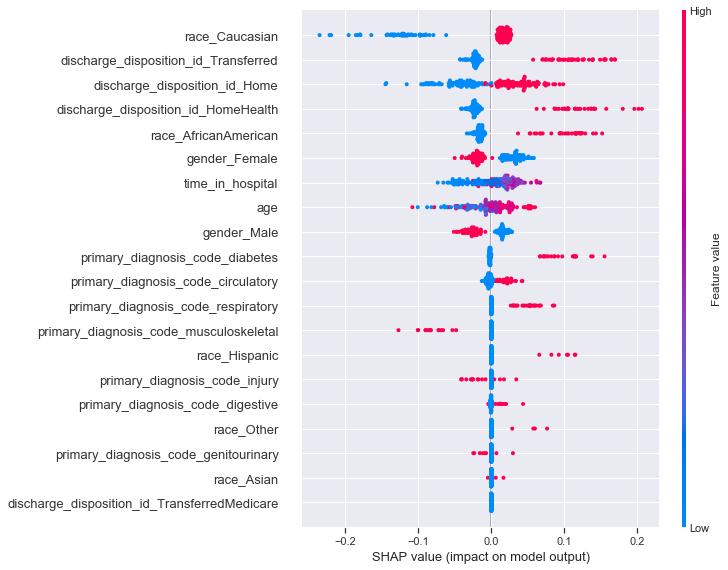

In [239]:
# Summarize the Shapley values in a plot
shap.summary_plot(shap_values[0], X_test_trans.sample(n=200, random_state=42))

> Explanation of Feature Importance Visual:
- The y-axis shows the feature importance scale from top to bottom.
- The sorted order of features gives the relative importance ranking of features ... is the most important feature
- The x-axis = see the Shapley values impact on model output
- Feature values are either red, which stands for high values 
- or blue which is for low values


In [241]:
INSTANCE_NUM = 0
shap.force_plot(explainer.expected_value[0], 
                shap_values[0][INSTANCE_NUM], 
                X_train_trans.iloc[INSTANCE_NUM,:])

Single point visualization:
- This shows what features change the base value towards zero 
- The base value is the average model output over the training set
- The features in red are pushing the label to a higher value 
- The features in blue are pushing lower


In [242]:
# Plot the SHAP values for multiple instances
NUM_ROWS = 10
shap.force_plot(explainer.expected_value[0], 
                shap_values[0][0:NUM_ROWS], 
                X_train_trans.iloc[0:NUM_ROWS])

Larger Sample:
- expand it to a sample of 10 points